# Model and Evaluation - Predict Sales Price

### objectives

* Fit and evaluate a regression model to predict Sales Price
* Utilise Hyperparameter Optimisation and Grid Search CV to design a well suited and functioning model.

### inputs

* outputs/datasets/cleaned/clean_house_price_records.csv

### Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here.

___

## Change working Directory

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/CI-Project-5-Predictive-Analytics/jupyter_notebooks'


We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/CI-Project-5-Predictive-Analytics'

## Load Cleaned Data and Import Necessary Packages

In [4]:

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

from sklearn.decomposition import PCA



___

## Load the required cleaned data

Transform the .csv file into a pandas data frame.

In [5]:
df = pd.read_csv(f"outputs/datasets/cleaned/clean_house_price_records.csv")
print(df.shape)
df.head()

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,No,706,GLQ,150,548,RFn,2003,1710,Gd,8450,65,196,61,5,7,856,2003,2003,208500
1,1262,0,3,Gd,978,ALQ,284,460,RFn,1976,1262,TA,9600,80,0,0,8,6,1262,1976,1976,181500
2,920,866,3,Mn,486,GLQ,434,608,RFn,2001,1786,Gd,11250,68,162,42,5,7,920,2001,2002,223500
3,961,0,0,No,216,ALQ,540,642,Unf,1998,1717,Gd,9550,60,0,35,5,7,756,1915,1970,140000
4,1145,0,4,Av,655,GLQ,490,836,RFn,2000,2198,Gd,14260,84,350,84,5,8,1145,2000,2000,250000


___

### Define the ML Regressor Pipeline

* The pipeline below implements the feature engineering steps that we concluded on in the previous notebook.

In [6]:
def PipelineOptimisation(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                   variables=['BsmtExposure',
                                                              'BsmtFinType1',
                                                              'GarageFinish',
                                                              'KitchenQual'])),
        
        ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea',])),
        
        ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['BsmtUnfSF'])),
        
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                            method="spearman",
                                                            threshold=0.6,
                                                            selection_method="cardinality")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

### Hyperparameter Optimisation

* Below is the Hyperparameter Optimisation function as defined in the Code Institute lesson material relating to Machine Learning.

In [7]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineOptimisation(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 21) (1168,) (292, 21) (292,)


### Grid Search CV - Sklearn.

* We shall use the default hyperparameters to search through the algorithms.

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


* We can now check the results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.676578,0.798403,0.862491,0.071609
2,RandomForestRegressor,0.701255,0.79697,0.844212,0.055843
5,GradientBoostingRegressor,0.608028,0.778348,0.841748,0.088047
0,LinearRegression,0.658521,0.737333,0.822257,0.056768
6,XGBRegressor,0.595537,0.727124,0.775717,0.066604
4,AdaBoostRegressor,0.564369,0.700756,0.751493,0.070433
1,DecisionTreeRegressor,0.312063,0.551501,0.648486,0.122515


* If we return to our business case specifically point 9 "What are the criteria for the performance goal of the predictions?". We can see that the minimum requirement of an r2 score is 0.75.
* If we look at the top 3 algorithms we see that all 3 pass this criteria when we review the mean_score. 
* ExtraTreesRegressor appears to be the best.
* We shall do an extensive search on this algorithm to determine the best hyperparameters. 

In [12]:
models_search = {
    "ExtraTreesRegressor":RandomForestRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [50,100,150,200,250,300,500,1000],
        'model__max_depth': [2,8,16,32,None],
    }
}

In [13]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
19,ExtraTreesRegressor,0.706932,0.803771,0.84859,0.054214,16,200
18,ExtraTreesRegressor,0.705478,0.802556,0.848687,0.054865,16,150
20,ExtraTreesRegressor,0.703491,0.8018,0.847821,0.055487,16,250
21,ExtraTreesRegressor,0.702522,0.800943,0.848183,0.055892,16,300
17,ExtraTreesRegressor,0.703403,0.800733,0.845799,0.054369,16,100
27,ExtraTreesRegressor,0.703855,0.8004,0.848546,0.056089,32,200
35,ExtraTreesRegressor,0.703855,0.8004,0.848546,0.056089,None,200
36,ExtraTreesRegressor,0.70269,0.799384,0.848151,0.056461,None,250
28,ExtraTreesRegressor,0.70269,0.799384,0.848151,0.056461,32,250
26,ExtraTreesRegressor,0.703555,0.799378,0.848423,0.056369,32,150


* After an extensive search where I spent time adjusting the values of our Hyperparameters we can clearly see that the  ExtraTreesRegroosr with a max_depth of 16 and an n_estimators of 200 is the most optimised.
* To reitterate the goal was an r2 of 0.75.
* with our tuned Hyperparameters:
    * min r2 = 0.706932 
    * max r2 = 0.84859
    * mean r2 = 0.803771
    * std r2 = 0.054214

In [15]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [16]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 16, 'model__n_estimators': 200}

___

### Assess feature importance

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea',
                                           'LotArea'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['BsmtUnfSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='cardinality',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model',
                 RandomForestRegressor(max_depth=16, n_estimators=200,
                                       random_state=0))])

* These are the 4 most important features in descending order. The model was trained on them: 
['1stFlrSF', 'GarageArea', 'GrLivArea', 'YearBuilt']


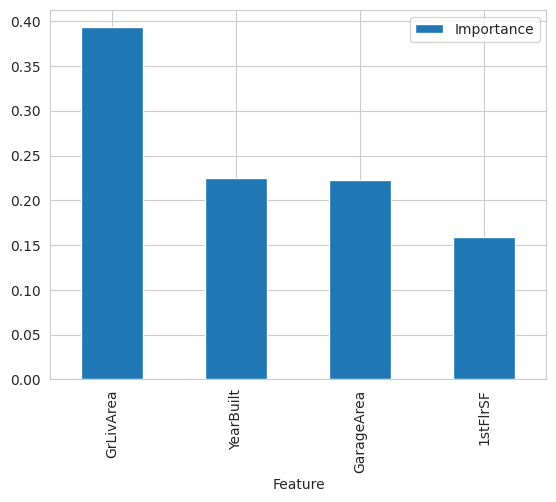

In [20]:
sns.set_style('whitegrid')

%matplotlib inline

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 4 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

* What this plot shows us is that the 4 most important features needed to determine SalesPrice are as follows:
    * GrLivArea
    * YearBuilt
    * GarageArea
    * 1stFlrSf


___

### Evaluate Pipeline Performace on Train and Test sets

In [ ]:
def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

## Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)